# Enoncé
Pour réaliser cet exercice, vous allez devoir à la fois manipuler des concepts vu en cours ainsi d'autres non acquis. Vous allez devoir prendre le temps de lire la documentation des différentes bibliothèques.

Vous devez créer un modèle de prédiction d'usage d'un système de vélos en libre service. Pour celà, vous avez collecté pendant plusieurs mois les données d'utilisation du système de la ville de Parme ainsi que des données météo associées. Vous devez nettoyer ces données afin qu'elles soient directement exploitables par la bibliothèque de machine learning de votre choix.


Les données sont accessibles sur ent: brut.zip

## Travail demandé

Écrivez le code qui permet de :

1. lire les données brutes directement depuis le fichier zip sans étape de décompression intermédiaire (voir les modules zipfile et pandas);

2. supprimer les données abérentes (dates/heures impossibles, données invalide, erreur de collecte) ;

3. normaliser le nom des stations (les noms peuvent avoir changé au cours du temps) grâce au fichier brut/bicincitta_parma_summary.csv ;

4. ré-échantilloner les données pour avoir un enregistrement toutes les 10 minutes(au lieu de 5 minutes (voir la méthode resample des DataFrames);

5. fusionner les données vélo et météo (voir la méthode merge des DataFrames);

6. stocker les données transformées sous la forme suivante :
        6.1 dossier différent par station (soit 24 dossiers) (voir groupby);
        6.2 Dans chaque dossier, 1 fichier par sous-série temporelle au format .csv.gz. Une sous série temporelle contient tous les exemples consécutif d'une station. Le nombre de sous séries dépend du nombre de "trous" dans les données (i.e., le nombre de fois où il y a plus de 10 minutes d'écart entre deux enregistrements consécutifs). Il s'agit probablement de la partie la plus compliquée de ce travail. À vous de trouver comment détecter cette présence de trous.
Il est préférable, mais pas obligatoire, d'utiliser une barre de progression pour donner une idée de la quantité de calcul restant et de l'attente.

Le contenu généré dans un fichier d'une sous-série doit ressembler à:


Timestamp;Station;Bikes;Slots;Total;Status;Humidity;Pressure;Rain;WindDeg;WindSpeed;Snow;TemperatureTemp
2018-01-25 11:20:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};5.7
2018-01-25 11:30:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};5.69
2018-01-25 11:40:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};5.69
2018-01-25 11:50:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};6.64
2018-01-25 12:00:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};5.78
2018-01-25 12:10:00;01. Duc;3;5;8;Mist;81.0;1028.0;{};240;1.5;{};5.78
2018-01-25 12:20:00;01. Duc;3;5;8;Mist;75.0;1027.0;{};290;2.1;{};6.47
2018-01-25 12:30:00;01. Duc;3;5;8;Mist;75.0;1027.0;{};290;2.1;{};6.46
2018-01-25 12:40:00;01. Duc;3;5;8;Mist;75.0;1027.0;{};290;2.1;{};6.44
2018-01-25 12:50:00;01. Duc;3;5;8;Mist;75.0;1027.0;{};290;2.1;{};8.0
2018-01-25 13:00:00;01. Duc;3;4;7;Mist;75.0;1027.0;{};290;2.1;{};6.79
2018-01-25 13:10:00;01. Duc;3;4;7;Mist;75.0;1027.0;{};290;2.1;{};6.79


Le format des données vélo est le suivant :

date;Station;Status;Nombre de vélos disponibles;Nombre d'emplacements disponibles



Le format des données climat est le suivant :

Timestamp;Status;Clouds;Humidity;Pressure;Rain;"WindGust;WindVarEnd;WindVarBeg;Wind


Il n'y a pas besoin de comprendre le sens des colonnes pour effectuer le travail. Voici un extrait de fichier.

# Remarques

1. Pour des raisons d'efficacité, il est préférable de travailler avec des extraits de données lors de la phase de développement
2. Vous pouvez effectuer le nettoyage en plusieurs étapes intérmédiaires avec sauvegarde 
3. Utilisez les bibliothèques de votre choix
4. La partie apprentissage ne nous intéresse pas du tout pour ce projet.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import zipfile as zip

    1 : Ouverture fichier depuis le zip

In [2]:
with zip.ZipFile("brut.zip") as z:
    with z.open("brut/bicincitta_parma_summary.csv") as f:
        velo_parma_summary_brut = pd.read_csv(f, delimiter=";")
    with z.open("brut/status_bicincitta_parma.csv") as f:
        status_velo_parma_brut = pd.read_csv(f, header=None, delimiter=";", names=['Timestamp', 'Station', 'Valide', 'Velos disponibles', 'Emplacements disponibles'])
    with z.open("brut/weather_bicincitta_parma.csv") as f:
        meteo_velo_parma_brut = pd.read_csv(f, header=None, delimiter=";", names=['Timestamp', 'Status', 'Nuage', 'Humidité', 'Pression', 'Pluie', 'Rafale de vent', 'Variation fin', 'Variation début', 'WindDeg', 'Vitesse du vent', 'Neige', 'Temperature max', 'Temperature min', 'Temperature'])

In [3]:
velo_parma_summary_brut.head()

,system,station,latitude,longitude,elevation
0,bicincitta_parma,01. Duc,44.807118,10.332934,51.076065
1,bicincitta_parma,02. Ospedale Maggiore,44.802263,10.306275,56.344078
2,bicincitta_parma,03. Traversetolo,44.781595,10.344492,58.324486
3,bicincitta_parma,04. Campus Chimica,44.766433,10.314547,76.587212
4,bicincitta_parma,05. Stazione FF.SS.,44.809888,10.327693,57.179089


In [4]:
status_velo_parma_brut.head()

,Timestamp,Station,Valide,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,1,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,1,2,7
2,2014-11-14 09:35:38,Traversetolo,1,2,7
3,2014-11-14 09:35:38,Campus Chimica,1,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,1,9,10


In [5]:
meteo_velo_parma_brut.head()

,Timestamp,Status,Nuage,Humidité,Pression,Pluie,Rafale de vent,Variation fin,Variation début,WindDeg,Vitesse du vent,Neige,Temperature max,Temperature min,Temperature
0,2014-11-14 09:35:38,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
1,2014-11-14 09:45:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2,2014-11-14 09:50:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
3,2014-11-14 09:55:05,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
4,2014-11-14 10:00:04,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0


    2 - Nettoyage des données abérentes

Cherchons tout d'abord quelles données sont abérentes afin de les nettoyer.

Déjà, on peut supprimer les lignes invalides du fichier statut_velo_parma.

In [6]:
status_velo_parma_valid = status_velo_parma_brut.query("Valide == 1")

In [7]:
status_velo_parma_valid.head()

,Timestamp,Station,Valide,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,1,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,1,2,7
2,2014-11-14 09:35:38,Traversetolo,1,2,7
3,2014-11-14 09:35:38,Campus Chimica,1,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,1,9,10


La colonne valide n'a maintenant plus d'intéret. On peut donc l'enlever :

In [8]:
status_velo_parma = status_velo_parma_valid.drop("Valide", axis=1)

In [9]:
status_velo_parma.head()

,Timestamp,Station,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,2,7
2,2014-11-14 09:35:38,Traversetolo,2,7
3,2014-11-14 09:35:38,Campus Chimica,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,9,10


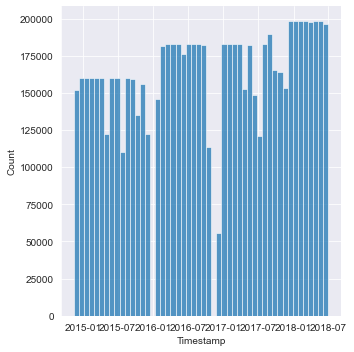

In [10]:
status_velo_parma['Timestamp'] = pd.to_datetime(status_velo_parma['Timestamp'])
sns.displot(status_velo_parma['Timestamp'], bins= 50, x= status_velo_parma['Timestamp'])

In [11]:
print(status_velo_parma['Timestamp'].min())
print(status_velo_parma['Timestamp'].max())

2014-11-14 09:35:38
2018-06-30 23:55:04


Les données date semblent être fiable. Pas de nettoyage nécessaire à ce niveau-là. On peut quand même souligner que nous avons deux périodes sans données.


In [12]:
status_velo_parma.head()

,Timestamp,Station,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,2,7
2,2014-11-14 09:35:38,Traversetolo,2,7
3,2014-11-14 09:35:38,Campus Chimica,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,9,10


In [13]:
print(velo_parma_summary_brut['system'].value_counts())

bicincitta_parma    24
Name: system, dtype: int64


In [14]:
print(velo_parma_summary_brut['station'].to_list())

['01. Duc', '02. Ospedale Maggiore', '03. Traversetolo', '04. Campus Chimica', '05. Stazione FF.SS.', '06. Ponte di Mezzo', '07. Santa Croce', '08. Bixio', '09. Farini', '10. Barilla Center', '11. Dus', '12. Barezzi', '13. Borgo XX Marzo', '14. Garibaldi', '15. Repubblica', '16. Toschi', '17. Rondani', '18. Crocetta', '19. Boito', '20. Efsa', '21. Kennedy', '22. Cittadella', '23. Vittoria', '24. Campus']


In [15]:
velo_parma_summary_brut['station'] = velo_parma_summary_brut['station'].astype(str)
velo_parma_summary = velo_parma_summary_brut
velo_parma_summary['station'] = velo_parma_summary_brut['station'].str.extract('(\d\d\.\s)(.*)')[1]

In [16]:
velo_parma_summary.head()

,system,station,latitude,longitude,elevation
0,bicincitta_parma,Duc,44.807118,10.332934,51.076065
1,bicincitta_parma,Ospedale Maggiore,44.802263,10.306275,56.344078
2,bicincitta_parma,Traversetolo,44.781595,10.344492,58.324486
3,bicincitta_parma,Campus Chimica,44.766433,10.314547,76.587212
4,bicincitta_parma,Stazione FF.SS.,44.809888,10.327693,57.179089


In [17]:
velo_parma_summary = velo_parma_summary.drop("system", axis=1)

In [18]:
velo_parma_summary.head()

,station,latitude,longitude,elevation
0,Duc,44.807118,10.332934,51.076065
1,Ospedale Maggiore,44.802263,10.306275,56.344078
2,Traversetolo,44.781595,10.344492,58.324486
3,Campus Chimica,44.766433,10.314547,76.587212
4,Stazione FF.SS.,44.809888,10.327693,57.179089


Le fichier velo_parma_summary devrait maintenant être utilisable.

Regardons le fichier météo.

In [19]:
meteo_velo_parma_brut.head()

,Timestamp,Status,Nuage,Humidité,Pression,Pluie,Rafale de vent,Variation fin,Variation début,WindDeg,Vitesse du vent,Neige,Temperature max,Temperature min,Temperature
0,2014-11-14 09:35:38,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
1,2014-11-14 09:45:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2,2014-11-14 09:50:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
3,2014-11-14 09:55:05,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
4,2014-11-14 10:00:04,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0


In [20]:
print(meteo_velo_parma_brut['Pluie'].value_counts())

{}                 277755
{u'3h': 0}           2518
{u'3h': 0.5}         1876
{u'3h': 1}           1816
{u'1h': 0.25}         908
                    ...  
{u'1h': 7.3}            1
{u'1h': 9.27}           1
{u'3h': 0.49}           1
{u'3h': 0.7325}         1
{u'1h': 2.96}           1
Name: Pluie, Length: 845, dtype: int64


Je n'arrive pas trop à comprendre la signification exacte du contenu de cette colonne. Supposition: Durée de la pluie et quantité de précipitation. D'après le fichier demandé en sortie, le nettoyage n'est pas encore requis. Cependant, ce n'est probablement pas exploitable sous cette forme.

Question 3

In [21]:
print(status_velo_parma['Station'].value_counts())

10. Barilla Center             194586
19. Boito                      194586
08. Bixio                      194586
12. Barezzi                    194586
13. Borgo XX Marzo             194585
04. Campus Chimica             194585
24. Campus                     194585
01. Duc                        194584
02. Ospedale Maggiore          194584
06. Ponte di Mezzo             194584
07. Santa Croce                194584
09. Farini                     194584
11. Dus                        194584
15. Repubblica                 194584
17. Rondani                    194584
18. Crocetta                   194584
20. Efsa                       194584
21. Kennedy                    194584
22. Cittadella                 194584
14. Garibaldi                  194584
23. Vittoria                   194583
16. Toschi                     194583
03. Traversetolo               194583
05. Stazione FF.SS.            194583
Stazione FF.SS.                144532
Traversetolo                   144532
Toschi      

In [22]:
status_velo_parma.head()

,Timestamp,Station,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,2,7
2,2014-11-14 09:35:38,Traversetolo,2,7
3,2014-11-14 09:35:38,Campus Chimica,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,9,10


In [23]:
status_velo_parma['Station'] = status_velo_parma['Station'].astype(str)
status_velo = status_velo_parma
status_velo['Station'] = status_velo_parma['Station'].str.extract('(\d?\d?\.?\s?)(.*)')[1]

In [24]:
print(status_velo['Station'].value_counts())

Duc                        339115
Barezzi                    339115
Kennedy                    339115
Efsa                       339115
Boito                      339115
Crocetta                   339115
Rondani                    339115
Toschi                     339115
Repubblica                 339115
Ospedale Maggiore          339115
Borgo XX Marzo             339115
Garibaldi                  339115
Dus                        339115
Barilla Center             339115
Farini                     339115
Bixio                      339115
Santa Croce                339115
Ponte di Mezzo             339115
Stazione FF.SS.            339115
Campus Chimica             339115
Traversetolo               339115
Cittadella                 225084
Vittoria                   225084
Campus                     225083
Palasport                   82670
Ospedale - viale Osacca     80893
Ospedale                     1778
Name: Station, dtype: int64


On observe 3 valeurs beaucoup moins représentées. Ce sont probablement les stations ayant changé de nom.

In [25]:
print(velo_parma_summary['station'])

0                   Duc
1     Ospedale Maggiore
2          Traversetolo
3        Campus Chimica
4       Stazione FF.SS.
5        Ponte di Mezzo
6           Santa Croce
7                 Bixio
8                Farini
9        Barilla Center
10                  Dus
11              Barezzi
12       Borgo XX Marzo
13            Garibaldi
14           Repubblica
15               Toschi
16              Rondani
17             Crocetta
18                Boito
19                 Efsa
20              Kennedy
21           Cittadella
22             Vittoria
23               Campus
Name: station, dtype: object


In [26]:
status_velo['Station'].replace(['Ospedale', 'Ospedale - viale Osacca'], 'Ospedale Maggiore', inplace=True)

In [27]:
print(status_velo['Station'].value_counts())

Ospedale Maggiore    421786
Duc                  339115
Barezzi              339115
Kennedy              339115
Efsa                 339115
Boito                339115
Crocetta             339115
Rondani              339115
Toschi               339115
Repubblica           339115
Garibaldi            339115
Borgo XX Marzo       339115
Dus                  339115
Barilla Center       339115
Farini               339115
Bixio                339115
Santa Croce          339115
Ponte di Mezzo       339115
Stazione FF.SS.      339115
Campus Chimica       339115
Traversetolo         339115
Cittadella           225084
Vittoria             225084
Campus               225083
Palasport             82670
Name: Station, dtype: int64


Palasport n'existe plus. Et le nom est proche d'aucune autre station actuellement existante. On peut supprimer les lignes de cette valeur


In [28]:
status_velo.head()

,Timestamp,Station,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,2,7
2,2014-11-14 09:35:38,Traversetolo,2,7
3,2014-11-14 09:35:38,Campus Chimica,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,9,10


In [29]:
status_velo = status_velo.query("Station != 'Palasport'")

In [30]:
print(status_velo['Station'].value_counts())

Ospedale Maggiore    421786
Duc                  339115
Barezzi              339115
Kennedy              339115
Efsa                 339115
Boito                339115
Crocetta             339115
Rondani              339115
Toschi               339115
Repubblica           339115
Garibaldi            339115
Borgo XX Marzo       339115
Dus                  339115
Barilla Center       339115
Farini               339115
Bixio                339115
Santa Croce          339115
Ponte di Mezzo       339115
Stazione FF.SS.      339115
Campus Chimica       339115
Traversetolo         339115
Cittadella           225084
Vittoria             225084
Campus               225083
Name: Station, dtype: int64


Etat actuel de nos données :

In [31]:
status_velo.head()

,Timestamp,Station,Velos disponibles,Emplacements disponibles
0,2014-11-14 09:35:38,Duc,4,5
1,2014-11-14 09:35:38,Ospedale Maggiore,2,7
2,2014-11-14 09:35:38,Traversetolo,2,7
3,2014-11-14 09:35:38,Campus Chimica,4,5
4,2014-11-14 09:35:38,Stazione FF.SS.,9,10


In [32]:
meteo_velo_parma_brut.head()

,Timestamp,Status,Nuage,Humidité,Pression,Pluie,Rafale de vent,Variation fin,Variation début,WindDeg,Vitesse du vent,Neige,Temperature max,Temperature min,Temperature
0,2014-11-14 09:35:38,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
1,2014-11-14 09:45:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2,2014-11-14 09:50:05,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
3,2014-11-14 09:55:05,clouds,40,100,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
4,2014-11-14 10:00:04,mist,40,100,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0


In [33]:
velo_parma_summary.head()

,station,latitude,longitude,elevation
0,Duc,44.807118,10.332934,51.076065
1,Ospedale Maggiore,44.802263,10.306275,56.344078
2,Traversetolo,44.781595,10.344492,58.324486
3,Campus Chimica,44.766433,10.314547,76.587212
4,Stazione FF.SS.,44.809888,10.327693,57.179089


Question 4

In [36]:
status_velo_resample = status_velo.groupby("Station", group_keys=False).resample('10T', on="Timestamp", origin='start').first()
meteo_velo_parma_brut["Timestamp"] = pd.to_datetime(meteo_velo_parma_brut["Timestamp"])
meteo_velo_resample = meteo_velo_parma_brut.resample('10T', on="Timestamp", origin='start').first()

In [41]:
status_velo_resample = status_velo_resample.drop("Timestamp", axis=1)
meteo_velo_resample = meteo_velo_resample.drop("Timestamp", axis=1)

In [42]:
status_velo_resample.head()

,Station,Velos disponibles,Emplacements disponibles
Timestamp,,,
2014-11-14 09:35:38,Barezzi,4.0,5.0
2014-11-14 09:45:38,Barezzi,4.0,5.0
2014-11-14 09:55:38,Barezzi,4.0,5.0
2014-11-14 10:05:38,Barezzi,4.0,5.0
2014-11-14 10:15:38,Barezzi,4.0,5.0


In [43]:
meteo_velo_resample.head()

,Status,Nuage,Humidité,Pression,Pluie,Rafale de vent,Variation fin,Variation début,WindDeg,Vitesse du vent,Neige,Temperature max,Temperature min,Temperature
Timestamp,,,,,,,,,,,,,,
2014-11-14 09:35:38,clouds,40.0,100.0,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
2014-11-14 09:45:38,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2014-11-14 09:55:38,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2014-11-14 10:05:38,clouds,40.0,100.0,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
2014-11-14 10:15:38,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0


On observe que nous avons bien des valeurs toutes les 10mn.

Question 5:

In [55]:
meteo_statut_velo = pd.merge(status_velo_resample, meteo_velo_resample, how='left', on="Timestamp")

In [52]:
meteo_statut_velo.head()

,Station,Velos disponibles,Emplacements disponibles,Status,Nuage,Humidité,Pression,Pluie,Rafale de vent,Variation fin,Variation début,WindDeg,Vitesse du vent,Neige,Temperature max,Temperature min,Temperature
Timestamp,,,,,,,,,,,,,,,,,
2014-11-14 09:35:38,Barezzi,4.0,5.0,clouds,40.0,100.0,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
2014-11-14 09:45:38,Barezzi,4.0,5.0,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2014-11-14 09:55:38,Barezzi,4.0,5.0,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0
2014-11-14 10:05:38,Barezzi,4.0,5.0,clouds,40.0,100.0,1013.0,{u'3h': 0},None,None,None,200.504,0.84,{},9.0,9.0,9.0
2014-11-14 10:15:38,Barezzi,4.0,5.0,mist,40.0,100.0,1014.0,{u'3h': 0},None,None,None,200.504,0.84,{},10.0,10.0,10.0


Question 6:
    6.1)

Besoin d'abord de préparation des données. Nous avons besoin de :
    Timestamp;Station;Bikes;Slots;Total;Status;Humidity;Pressure;Rain;WindDeg;WindSpeed;Snow;TemperatureTemp

In [56]:
meteo_statut_velo.drop(columns=["Nuage", "Rafale de vent", "Variation fin", "Variation début", "Temperature max", "Temperature min"], inplace=True, axis=1)

In [58]:
meteo_statut_velo.head()

,Station,Velos disponibles,Emplacements disponibles,Status,Humidité,Pression,Pluie,WindDeg,Vitesse du vent,Neige,Temperature
Timestamp,,,,,,,,,,,
2014-11-14 09:35:38,Barezzi,4.0,5.0,clouds,100.0,1013.0,{u'3h': 0},200.504,0.84,{},9.0
2014-11-14 09:45:38,Barezzi,4.0,5.0,mist,100.0,1014.0,{u'3h': 0},200.504,0.84,{},10.0
2014-11-14 09:55:38,Barezzi,4.0,5.0,mist,100.0,1014.0,{u'3h': 0},200.504,0.84,{},10.0
2014-11-14 10:05:38,Barezzi,4.0,5.0,clouds,100.0,1013.0,{u'3h': 0},200.504,0.84,{},9.0
2014-11-14 10:15:38,Barezzi,4.0,5.0,mist,100.0,1014.0,{u'3h': 0},200.504,0.84,{},10.0
